# fvGP comprehensive test

## (0) Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp.gp import GP
%load_ext autoreload
%autoreload 2

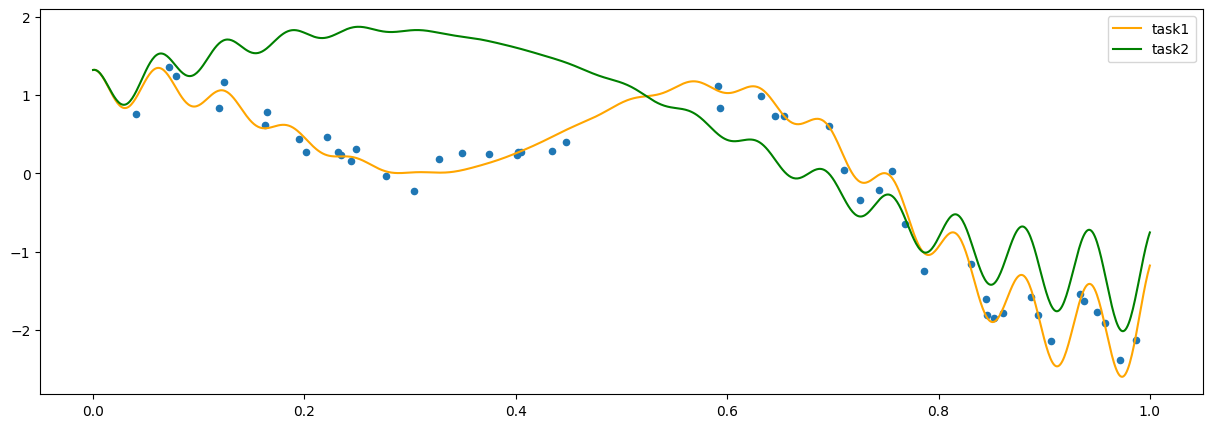

In [4]:
x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

def f2(x):
    return np.sin(5. * x) + np.cos(2. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(50)
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.plot(x,f2(x), color = 'green',  label = 'task2')
plt.legend()
plt.scatter(x_data,y_data, s = 20)

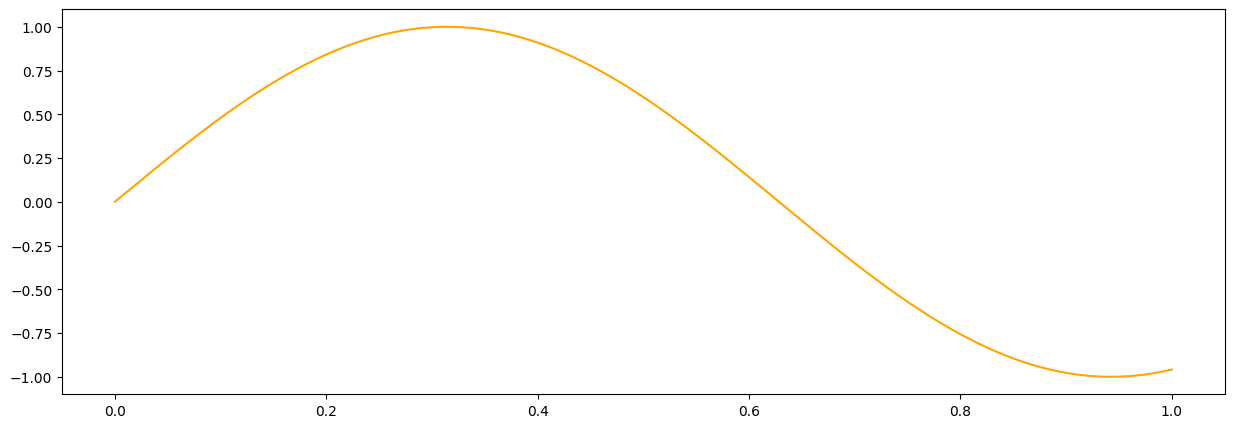

In [5]:
#stationary
def skernel(x1,x2,hps,obj):
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

def meanf(x, hps, obj):
    return np.sin(hps[2] * x)
plt.figure(figsize = (15,5))
plt.plot(x,meanf(x, np.array([1.,1.,5.0]), None), color = 'orange', label = 'task1')

In [11]:
my_gp1 = GP(1, x_data,y_data,np.ones((2)),
            variances=None, 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=None, 
            gp_mean_function_grad=None,  
            normalize_y=False, 
            store_inv=True, 
            ram_economy=True, 
            args=None,
            )

x_pred = np.linspace(0,1,1000)
opt_obj = my_gp1.train(np.array([[0.001,10.],[0.001,10.]]))
#my_gp1.train(np.array([[0.001,10.],[0.001,10.]]))
#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

2023-07-17 09:30:57,453 - distributed.protocol.pickle - ERROR - Failed to serialize <hgdl.meta_data.meta_data object at 0x7f2002023670>.
Traceback (most recent call last):
  File "/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
_pickle.PicklingError: Can't pickle <class 'fvgp.gp.GP'>: it's not the same object as fvgp.gp.GP

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
_pickle.PicklingError: Can't pickle <class 'fvgp.gp.GP'>: it's not the same object as fvgp.gp.GP

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/distributed/protocol/

type: ('Could not serialize object of type meta_data', '<hgdl.meta_data.meta_data object at 0x7f2002023670>')

In [ ]:
my_gp1.update_hyperparameters(opt_obj)
for entry in opt_obj.optima.list:
    print(entry)
    print("")

#my_gp1.entropy(my_gp1.prior_covariance)

In [ ]:
#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

In [ ]:
my_gp1.stop_training(opt_obj)
my_gp1.kill_training(opt_obj)

# Performance Tests

In [ ]:
A = np.random.rand(5000,5000)
B = A.T @ A
b = np.random.rand(5000)
%timeit np.linalg.solve(B,b )

In [ ]:
from scipy.linalg import lu_factor, lu_solve
def solve_lu(Matrix,vec):
    lu, piv = lu_factor(Matrix)
    x = lu_solve((lu, piv), vec)
    return x



from scipy.linalg import cholesky
from scipy.linalg import cho_factor, cho_solve
def solve_chol(Matrix,vec):
    c, low = cho_factor(Matrix)
    x = cho_solve((c, low), vec)
    return x

In [ ]:
%timeit solve_lu(B,b)

In [ ]:
%timeit solve_chol(B,b)

In [ ]:
np.linalg.slogdet(B)

In [ ]:
from scipy.linalg import lu
u, piv = lu_factor(B)
upper_diag = abs(u.diagonal())
r = np.sum(np.log(upper_diag))
print("LU logdet: ",r)

u, low = cho_factor(B)
upper_diag = abs(u.diagonal())
r = 2.0 * np.sum(np.log(upper_diag))
print("chol logdet: ", r)
print("scipy logdet: ",np.linalg.slogdet(B))

In [ ]:
lu, piv = lu_factor(B)
%timeit x = lu_solve((lu, piv), b)

In [ ]:
%timeit torch.cholesky(torch.tensor(B))
%timeit np.linalg.cholesky(B)
%timeit cholesky(B)
print("--------[]")
%timeit torch.lu(torch.tensor(B))
%timeit lu(B)

In [ ]:
c, low = cho_factor(B)
%timeit x = cho_solve((c, low), b)
Binv = np.linalg.inv(B)
%timeit Binv @ b

In [ ]:
from sksparse.cholmod import cholesky

In [ ]:
!pip install sksparse


In [ ]:
import warnings
warnings.warn("cfv \n\
cwec")